# Testing pipeline

In [1]:
import rootutils

rootutils.setup_root(
    search_from='.',
    indicator=[".git", "pyproject.toml"],
    project_root_env_var=True, # set the PROJECT_ROOT environment variable to root directory
    dotenv=True, # load environment variables from .env if exists in root directory
    pythonpath=True, # add root directory to the PYTHONPATH (helps with imports)
    cwd=True, # change current working directory to the root directory (helps with filepaths)
)

PosixPath('/home/milton/workspace/lca')

In [2]:
import numpy as np
import h5py

filepath = "data/datasets/emojis/animal_emojis_n_variants_0.h5"

with h5py.File(filepath, "r") as f:
    images = np.array(f["images"])
    token_emb = np.array(f['token_embeddings'])


In [3]:
import jax.random as jr
from src.model.lca import AttentionLCA

lca = AttentionLCA(
    token_dim=token_emb.shape[-1],
    hidden_size=128,
    update_width=token_emb.shape[-1] * 4,
    update_depth=2,
    key=jr.key(42)
)

In [4]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
from typing import Callable
from jaxtyping import Array, Float, PyTree

from src.nn.seeding import init_central_seed


def init_fn(b, shape):
    return np.repeat(init_central_seed((lca.state_size, *shape))[None], repeats=b, axis=0)


def compute_loss(
    model: Callable,
    batch: tuple[jax.Array, jax.Array],
    key: jax.Array
):
    inputs, targets = batch
    B, _, H, W = targets.shape
    
    batch_key = jr.split(key, B)
    init_states = init_fn(B, (H, W))
    preds, _ = jax.vmap(model)(init_states, inputs, batch_key)
    
    return jnp.sum(optax.l2_loss(preds, targets)) / len(targets)


@eqx.filter_jit
def train_step(
    model: PyTree,
    batch: tuple[Float[Array, "NCHW"], Float[Array, "NCHW"]],
    opt_state: PyTree,
    key: jax.Array,
):
    loss_value, grads = eqx.filter_value_and_grad(compute_loss)(model, batch, key)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return loss_value, model, opt_state

In [5]:
lr = 1e-4

optim = optax.chain(
    optax.clip_by_global_norm(1.0),
    # optax.clip_by_block_rms(1.0),
    optax.adamw(lr),
)
opt_state = optim.init(eqx.filter(lca, eqx.is_array))

In [6]:
from tqdm import tqdm

train_iters = 1000
batch = token_emb[:8], images[:8]
key = jr.key(42)

for i in (pbar := tqdm(range(train_iters))):
    key, step_key = jr.split(key, 2)
    train_loss, lca, opt_state = train_step(lca, batch, opt_state, step_key)
    pbar.set_postfix_str(f"iter: {i}; loss: {np.asarray(train_loss)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:12<00:00,  1.63it/s, iter: 999; loss: 4.183948516845703]


In [7]:
inputs, targets = batch
B, _, H, W = targets.shape
examples = jax.vmap(lca)(init_fn(B, (H, W)), inputs, jr.split(key, len(targets)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10165116..1.0675064].


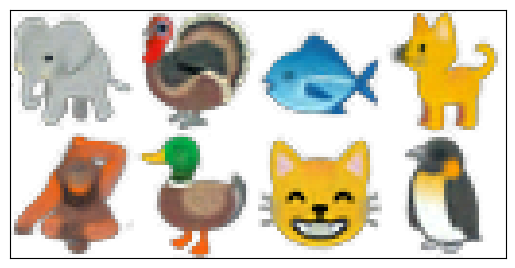

In [8]:
import matplotlib.pyplot as plt
from src.visualisation.utils import plot_examples

plot_examples(examples[0], w=4, format='NCHW');

In [9]:
from IPython.display import HTML
from src.visualisation.dev import plot_dev_path

ani = plot_dev_path(examples[1][0, :, :4])
HTML(ani.to_jshtml())